# Introduction

Businesses have evolved to the point where facts, metrics and data are used to guide strategic business decisions that align with business goals, objectives, and initiatives. 

This notebook looks at a business problem in a mail-order catalog business. 

#### Description of problem

The company manufactures and sells high-end home goods. Last year, the company sent out its first print catalog, and is preparing to send out this year's catalog in the coming months to their new customers. The company has 250 new customers from their mailing list that they want to send the catalog to.

#### Undecided decision

Management want to make a decision based on the `expected profits` from sending a catalog to these customers. They do not want to send the catalog out to these new customers unless the `expected profit contribution` exceeds **10,000** dollars. 

#### Given information

From management we know the

- costs of printing and distributing catalogs (**6.50** per catalog).
- We also know the average gross margin (price - cost) on all products sold through the catalog is 50%.

#### Task

The task is to predict how much money the company can expect to earn from sending out a catalog to their new customers.

## Analysis Steps

`1.` **Data Exploration**: What are the features correlated with average sales amounts, based on the existing customer data?

2) **Build a predictive model**: build a predictive model with the features from step one to predict the average sales amount of the new customers

3) **Estimate the expected revenue**: By multiplying the predicted sales amount with the probability that each new customer will buy our catalog, we can get this expected revenue information these 250 people.

4) **Aggregated revenue**: The aggregated revenue should be multiplied with the average gross margin. 

5) Next, the total costs of catalog for 250 customers should be subtracted.

6) **Decision making process**: Compare total expected net profit with the cut-off (10,000) provided by management. If the total expected profit contribution is larger than the cut-off value, sending this year's catalog to the new customers is recommended.

In [1]:
# Import the relevant libraries 
import pandas as pd 
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression 
import seaborn as sns 
sns.set()

%matplotlib inline
import pickle

## Data Processing

In [2]:
# Read the data 
df = pd.read_excel('p1-customers.xlsx')
df.head(2)

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,227.9,100,No,1,6
1,Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,55.0,105,Yes,1,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Name                        2375 non-null   object 
 1   Customer_Segment            2375 non-null   object 
 2   Customer_ID                 2375 non-null   int64  
 3   Address                     2375 non-null   object 
 4   City                        2375 non-null   object 
 5   State                       2375 non-null   object 
 6   ZIP                         2375 non-null   int64  
 7   Avg_Sale_Amount             2375 non-null   float64
 8   Store_Number                2375 non-null   int64  
 9   Responded_to_Last_Catalog   2375 non-null   object 
 10  Avg_Num_Products_Purchased  2375 non-null   int64  
 11  #_Years_as_Customer         2375 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 222.8+ KB


In [4]:
df.shape

(2375, 12)

In [5]:
df.isnull().any().sum()

0

In [7]:
df['Customer_ID'].nunique() == df.shape[0] #returns true is all customer id's are unique

True

In [8]:
df['Customer_Segment'].value_counts() #there are 4 categories of customer segment

Store Mailing List              1108
Loyalty Club Only                579
Credit Card Only                 494
Loyalty Club and Credit Card     194
Name: Customer_Segment, dtype: int64

In [9]:
df['City'].nunique() #customers live accross 27 cities

27

In [10]:
df['City'].value_counts() #a peek at the different cities

Denver               750
Aurora               493
Arvada               247
Lakewood             217
Broomfield           125
Westminster           85
Centennial            78
Littleton             72
Englewood             56
Wheat Ridge           54
Thornton              35
Parker                27
Northglenn            24
Highlands Ranch       23
Golden                19
Greenwood Village     14
Edgewater             12
Commerce City         10
Superior               9
Morrison               7
Lafayette              5
Louisville             4
Boulder                3
Brighton               2
Castle Pines           2
Henderson              1
Lone Tree              1
Name: City, dtype: int64

In [11]:
df['State'].value_counts() #state column is not useful, customers all live in the same state

CO    2375
Name: State, dtype: int64

In [12]:
df['Store_Number'].nunique() #there are 10 different stores

10

In [13]:
#drop non-informative features
df_clean = df.copy()
df_clean.drop(['Name','Address', 'State','ZIP'], axis = 1, inplace= True)

df_clean.head(3)

,Customer_Segment,Customer_ID,City,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Store Mailing List,2,Denver,227.90,100,No,1,6
1,Store Mailing List,7,Greenwood Village,55.00,105,Yes,1,6
2,Store Mailing List,8,Centennial,212.57,101,No,1,3


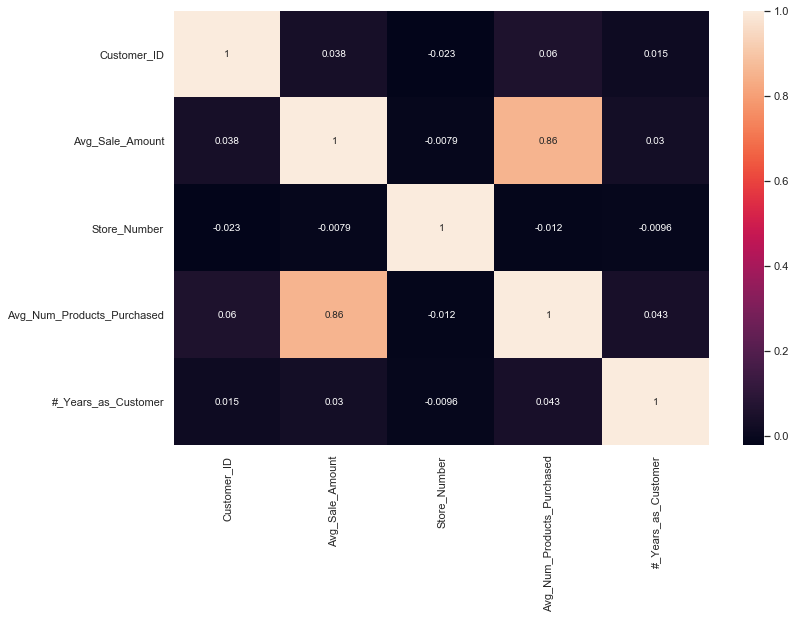

In [14]:
plt.figure(figsize=[12,8])
sns.heatmap(df_clean.corr(), annot=True);


Note: The correlation matrix plot above shows relationship for only numerical features in the dataset.

Looking at the correlation matrix, we see that

- **Avg_Sale_Amount** is highly corrlated with **Avg_Num_Products_Purchased** with coeff = 0.86
- **Avg_Sale_Amount** is moderately correlated with **#_Years_as_Customer** with coeff = 0.03
- There seem to be a correlation between **#_Years_as_Customer** and **Avg_Num_Products_Purchased**, but this is moderate with coeff = 0.043, thus we do not have to worry about multicollinearity if we might want to include any of them in our predictive model.

Let us see these relationships in visual form

In [18]:
#function to plot a horizontal bar chat of two columns in a dataframe
def bar_plot(df,x,y,xlabel,title):
    ax = df[[x, y]].plot(kind='barh', yticks = df.index, width=0.7, figsize=(8, 6),legend=None);
    ax.set_yticklabels(df[x]);
    ax.set_xlabel(xlabel)
    ax.grid(axis = 'x',linestyle = '--', linewidth = 0.5)
    plt.title(title);

### Customer Segment

#### Exploration

In [15]:
(df['Customer_Segment'].value_counts()/df.shape[0])

Store Mailing List              0.466526
Loyalty Club Only               0.243789
Credit Card Only                0.208000
Loyalty Club and Credit Card    0.081684
Name: Customer_Segment, dtype: float64

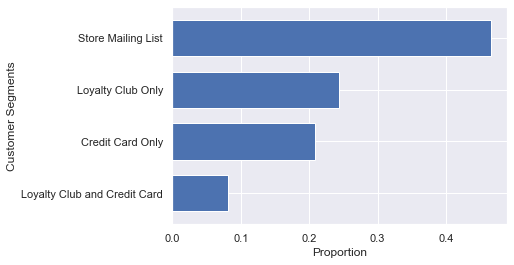

In [16]:
(df['Customer_Segment'].value_counts()/df.shape[0]).sort_values().plot(kind='barh',width = 0.7)
plt.xlabel('Proportion')
plt.ylabel("Customer Segments");
#plt.xticks(rotation=60);

#### Customer Segment vs Average Sale Amount

In [17]:
df_cus_avg = df_clean.groupby('Customer_Segment')['Avg_Sale_Amount'].mean().sort_values().reset_index()
df_cus_avg

,Customer_Segment,Avg_Sale_Amount
0,Store Mailing List,157.361525
1,Loyalty Club Only,396.332573
2,Credit Card Only,682.678947
3,Loyalty Club and Credit Card,1074.159485


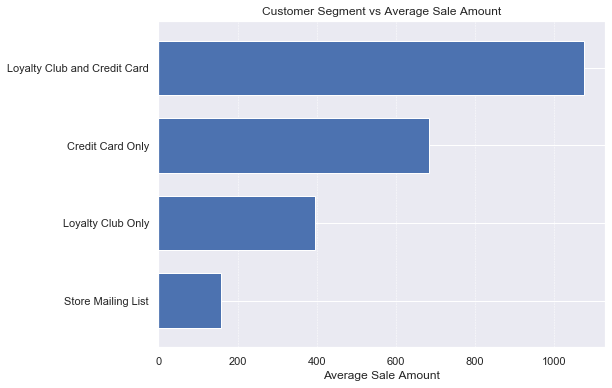

In [19]:
bar_plot(df_cus_avg,'Customer_Segment','Avg_Sale_Amount','Average Sale Amount','Customer Segment vs Average Sale Amount')

#### Customer Segment vs Number of Years as Customer

In [20]:
df_cus_years = df_clean.groupby('Customer_Segment')['#_Years_as_Customer'].mean().sort_values().reset_index()
df_cus_years

,Customer_Segment,#_Years_as_Customer
0,Store Mailing List,4.398917
1,Credit Card Only,4.502024
2,Loyalty Club Only,4.571675
3,Loyalty Club and Credit Card,4.865979


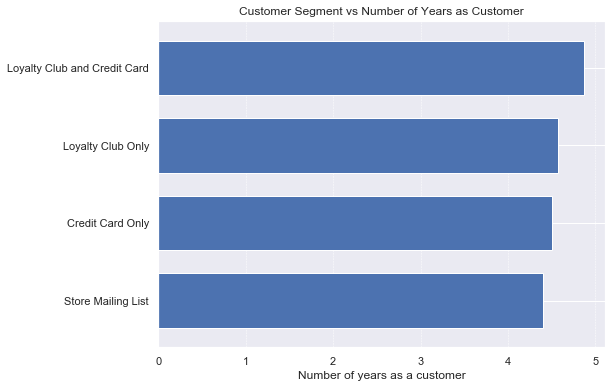

In [21]:
bar_plot(df_cus_years,'Customer_Segment','#_Years_as_Customer','Number of years as a customer','Customer Segment vs Number of Years as Customer')

Thus the relationship between Customer Segment and Number of Years as Customer is not very strong thus we dont have to worry about multicollinearity.


### Summary

- There are 4 categorized of customer segment:

 - Loyalty Club and Credit Card, Credit Card Only, Loyalty Club Only, and Store Mailing List, respectively, according to decreasing levels of customer loyalty.  

- The Store Mailing List segment has about 47%, Loyalty Club Only has 24%, Credit Card Only has 21% and Loyalty Club and Credit Card has about 8%, of the customer's population respectively. This indicates the number of customers in each segment decreases as they belong to  higher loyalty group.

- On the other hand, the average sales amount increases as the customers belong to higher loyalty club with **Loyalty Club and Credit Card** having the highest average sales of about 1074 and **Store Mailing List** with the least Average Sale Amount of 157.4.

- Thus included in our final predictive model will be the "Customer_Segment" feature.

### Store number

In [22]:
df_store_num = df_clean.groupby('Store_Number')['Avg_Sale_Amount'].mean().sort_values().reset_index()
df_store_num

,Store_Number,Avg_Sale_Amount
0,108,359.332333
1,102,380.428000
2,106,382.021979
3,104,386.272852
4,101,397.463913
5,103,406.493200
6,100,412.505491
7,107,414.002920
8,105,419.240852
9,109,427.162663


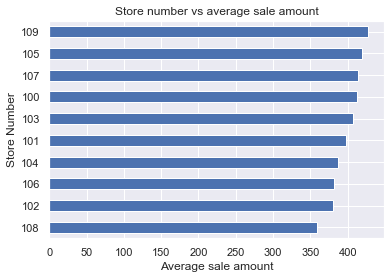

In [23]:
df_clean.groupby('Store_Number')['Avg_Sale_Amount'].mean().sort_values().plot(kind = 'barh');
plt.xlabel('Average sale amount')
plt.ylabel('Store Number')
plt.title('Store number vs average sale amount');

There is no practical significant difference between sales in each of these stores compared to another. This feature is not included in the final model.

### City

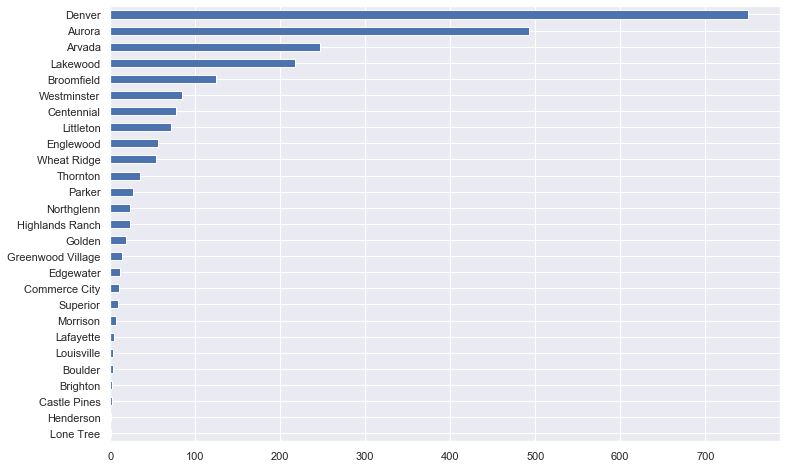

In [24]:
plt.figure(figsize = [12, 8])
df_clean['City'].value_counts().sort_values().plot(kind = 'barh');


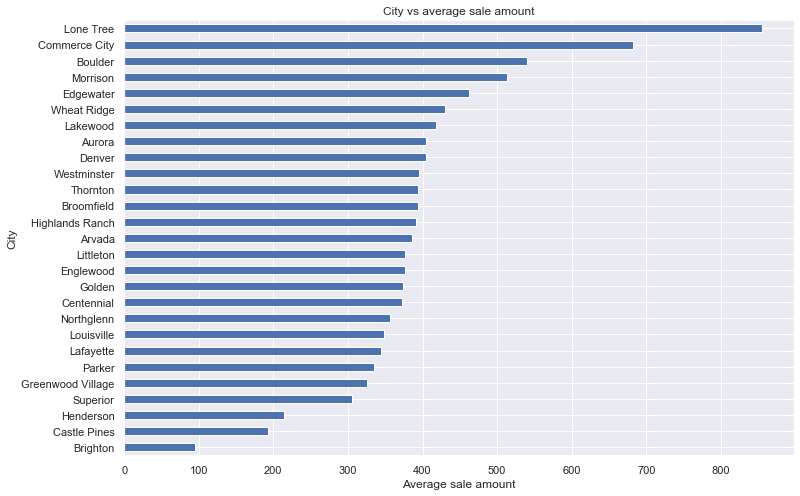

In [25]:
plt.figure(figsize = [12,8])
df_clean.groupby('City')['Avg_Sale_Amount'].mean().sort_values().plot(kind = 'barh');
plt.xlabel('Average sale amount')
plt.ylabel('City')
plt.title('City vs average sale amount');

A larger proportion of customers live in Denver, Aurora and Arbada respectively while the number of observations (cutomers) in Castle Pine, Lone Tree and Henderson are minimal. As a result, it is hard to generalize from the visualizations the effect of different cities on the average amount of sales. Thus, it is not included into the final model.

### Average Number of Products Purchased

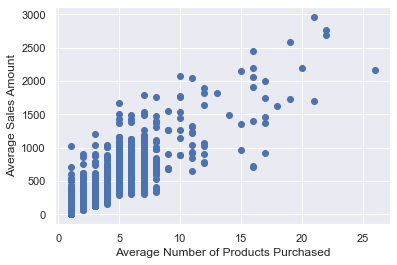

In [26]:
plt.scatter(data = df_clean, x = 'Avg_Num_Products_Purchased', y = 'Avg_Sale_Amount')
plt.xlabel('Average Number of Products Purchased')
plt.ylabel('Average Sales Amount');

The number of purchased products has obviously a positive relationship with the average sales amount. The more number of products customers purchase, the larger amount of average sales the company could achieve. Thus, I included this feature into the predictive model.

### Number of Years as Customers

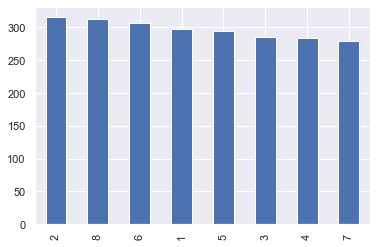

In [27]:
df_clean['#_Years_as_Customer'].value_counts().plot(kind='bar');

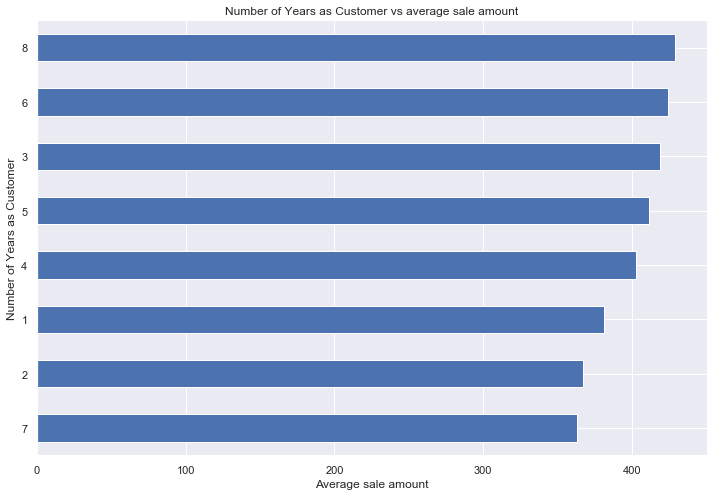

In [28]:
plt.figure(figsize = [12,8])
df_clean.groupby('#_Years_as_Customer')['Avg_Sale_Amount'].mean().sort_values().plot(kind = 'barh');
plt.xlabel('Average sale amount')
plt.ylabel('Number of Years as Customer')
plt.title('Number of Years as Customer vs average sale amount');

In [ ]:
plt.figure(figsize = [12,8])
df_clean.groupby('#_Years_as_Customer')['Avg_Sale_Amount'].mean().sort_values().plot(kind = 'barh');
plt.xlabel('Average sale amount')
plt.ylabel('Number of Years as Customer')
plt.title('Number of Years as Customer vs average sale amount');

Also, the number of years as customer does not show any clear relationship with the target variable. That is, increasing or decreasing number of years as customer does not necessarily have an influence on the sales amount on average. The feature is not selected for predictive model.

### Responded to Last Catalog

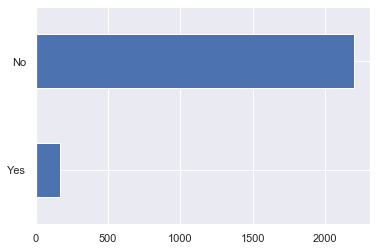

In [29]:
df_clean['Responded_to_Last_Catalog'].value_counts().sort_values().plot(kind='barh');

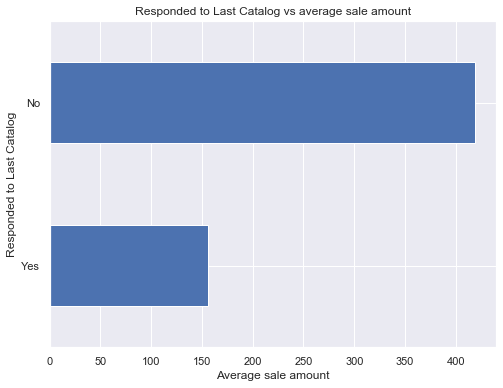

In [30]:
plt.figure(figsize = [8,6])
df_clean.groupby('Responded_to_Last_Catalog')['Avg_Sale_Amount'].mean().sort_values().plot(kind = 'barh');
plt.xlabel('Average sale amount')
plt.ylabel('Responded to Last Catalog')
plt.title('Responded to Last Catalog vs average sale amount');

Despite our observation here, since this variable is not included in the mailinglist dataset needed for our prediction, it is not going to be included in the model.

## Model Preparation

In [31]:
df2 = df_clean.copy()
df2.drop(['Customer_ID','Store_Number','City', 'Responded_to_Last_Catalog', '#_Years_as_Customer'], axis = 1, inplace = True) 

In [32]:
df2.head(3)

,Customer_Segment,Avg_Sale_Amount,Avg_Num_Products_Purchased
0,Store Mailing List,227.90,1
1,Store Mailing List,55.00,1
2,Store Mailing List,212.57,1


In [33]:
df_model = pd.get_dummies(df2, drop_first = True) # Make the categorical variable (Customer_Segment) to dummy variable

In [34]:
df_model.head()

,Avg_Sale_Amount,Avg_Num_Products_Purchased,Customer_Segment_Loyalty Club Only,Customer_Segment_Loyalty Club and Credit Card,Customer_Segment_Store Mailing List
0,227.90,1,0,0,1
1,55.00,1,0,0,1
2,212.57,1,0,0,1
3,195.31,1,0,0,1
4,110.55,1,0,0,1


In [65]:
y = df_model['Avg_Sale_Amount']
x = df_model.drop(['Avg_Sale_Amount'],axis =1)

In [66]:
x1 = sm.add_constant(x)
results = sm.OLS(y,x1).fit()

In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     3040.
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        05:17:25   Log-Likelihood:                -15061.
No. Observations:                2375   AIC:                         3.013e+04
Df Residuals:                    2370   BIC:                         3.016e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                           303.4635     10.576     28.694      0.000     282.725     324.202
Avg_Num_Products_Purchased                       66.9762      1.515     44.208      0.000      64.005      69.947
Customer_Segment_Loyalty Club Only             -149.3557      8.973    -16.645      0.000    -166.951    -131.760
Customer_Segment_Loyalty Club and Credit Card   281.8388     11.910     23.664      0.000     258.484     305.194
Customer_Segment_Store Mailing List            -245.4177      9.768    -25.125      0.000    -264.572    -226.263
==============================================================================
Omnibus:                      359.638   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4770.580
Skew:                           0.232   Prob(JB):                         0.00
Kurtosis:                       9.928   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Final Model 
- Included in our final predictive linear model are "Average Number of purchased products” and “Customer_Segment”.

The Best Linear Regression Equation is as follows:

\begin{align}
\text{Avg_Sale_Amount} &= 303.46 \\
                  & + 66.98 ~\text{Avg_Num_Products_Purchased}  \\
                  & - 149.36 ~\text{Customer_Segment_Loyalty Club Only}  \\
                  & +281.84 ~\text{Customer_Segment_Loyalty Club and Credit Card} \\
                  &- 245.42~ \text{Customer_Segment_Store Mailing List}
\end{align}

#### Hypothesis Testing

We can perform a hypothesis test for the coefficients in our linear models using Python. 
The hypothesis test for each x-variable is a test of if that population slope is equal to zero vs. an alternative where the parameter differs from zero.

Mathematically,

$
H_{0}: \beta_0 = 0\\
H_{1}: \beta_1 \neq 0
$

Therefore, if the slope is different than zero (the alternative is true), we have evidence that the x-variable attached to that coefficient has a statistically significant linear relationship with the response. This in turn suggests that the x-variable should help us in predicting the response (or at least be better than not having it in the model).
 
 #### Model Justification & Validation

- The R-squared value of the linear regression model is 0.837. This indicates that 83.7% of the data can be explained by the above-mentioned linear model.

- The p-values associated to each predictor variable (approximately 0) suggest that the explanatory variables are statistically significant and would help us in predicting the average sale amount for future customers.


Therefore, the linear model is valid, and the results are reliable.

Let us use the sklearn library in python.

In [70]:
reg_model = LinearRegression().fit(x,y)
print("R-squared:", reg_model.score(x, y))
print("Coefficients:",reg_model.coef_)
print("Intercept:",reg_model.intercept_)

R-squared: 0.8368777093556734
Coefficients: [  66.97620492 -149.35572194  281.83876492 -245.4177445 ]
Intercept: 303.4634713146725


We get the same results as with stat model

In [ ]:
 reg.predict(inputs)

In [71]:
#save model as pickle
pickle.dump(reg_model, open('reg_model.pickle', 'wb'))